## Load Modules

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from multiprocess import Pool
from joblib import Parallel, delayed
import datetime
import itertools
import psutil
#import jupyternotify

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
#import cufflinks as cf

from scipy import stats
import statsmodels.api as s
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb
from fastai import *
from fastai.tabular import *
from fbprophet import Prophet
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
pd.options.display.float_format = '{:.2f}'.format

Using TensorFlow backend.


In [ ]:
num_cpus = psutil.cpu_count(logical=False)
num_cpus
mp.cpu_count()

## Load dataframes

In [2]:
# Additional store data
store = pd.read_csv('store.csv')

# Importing train data to learn and test data
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date', low_memory = False)
test = pd.read_csv('test.csv', parse_dates = True, index_col = 'Date', low_memory = False)

## Preprocessing Data

#### Missing Values

In [3]:
# Remove nan values from column 'Open'

zero_index = test[test['Open'] == 0.00]
one_index = test[test['Open'] == 1.00]
test = pd.concat([zero_index,one_index])
test['Open'] = test.Open.astype(int)
#test.dtypes

In [4]:
store.isnull().sum()
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [5]:
# No Promo = No Promo since week/year 

_P = store[pd.isnull(store.Promo2SinceWeek)]
_P[_P.Promo2 != 0].shape

# Replace NA's with 0
store = store.fillna(0)

(0, 10)

In [6]:
# Remove closed and open stores with no sales
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

#### Data extraction

In [7]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# New variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.48
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.70
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.13
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.34
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.63


In [8]:
# Joining train data with additional store information

train_reset = train.reset_index()
store_train = pd.merge(train_reset, store, how = 'inner', on = 'Store')
store_train.head()
store_train.shape

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,...,9.48,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0
1,2015-07-30,1,4,5020,546,1,1,0,1,2015,...,9.19,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0
2,2015-07-29,1,3,4782,523,1,1,0,1,2015,...,9.14,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0
3,2015-07-28,1,2,5011,560,1,1,0,1,2015,...,8.95,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0
4,2015-07-27,1,1,6102,612,1,1,0,1,2015,...,9.97,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0


(844338, 23)

In [9]:
LE = LabelEncoder()
cat_to_num_col = ['StateHoliday', 'StoreType', 'Assortment']
new_col = ['State_Holiday', 'Store_Type', 'Assort_ment']
for i in range(0, len(cat_to_num_col)):
    store_train[new_col[i]] = LE.fit_transform(store_train[cat_to_num_col[i]])
    store_train = store_train.drop(cat_to_num_col[i], axis = 1)

store_train.columns


Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State_Holiday', 'Store_Type',
       'Assort_ment'],
      dtype='object')

In [10]:
store_85 = store_train[store_train['Store'] == 85].sort_index(ascending = False).reset_index().drop('index', axis = 1)
store_85_sales = store_85.loc[:, ['Date','Sales']]
store_85_sales['Date'] = pd.DatetimeIndex(store_85_sales['Date'])
#store_85.head()
store_85_sales.head()
store_85_sales.dtypes

,Date,Sales
0,2013-01-01,4220
1,2013-01-02,6069
2,2013-01-03,5246
3,2013-01-04,5339
4,2013-01-05,5774


Date     datetime64[ns]
Sales             int64
dtype: object

## Exploring Data

#### Correlation Analysis

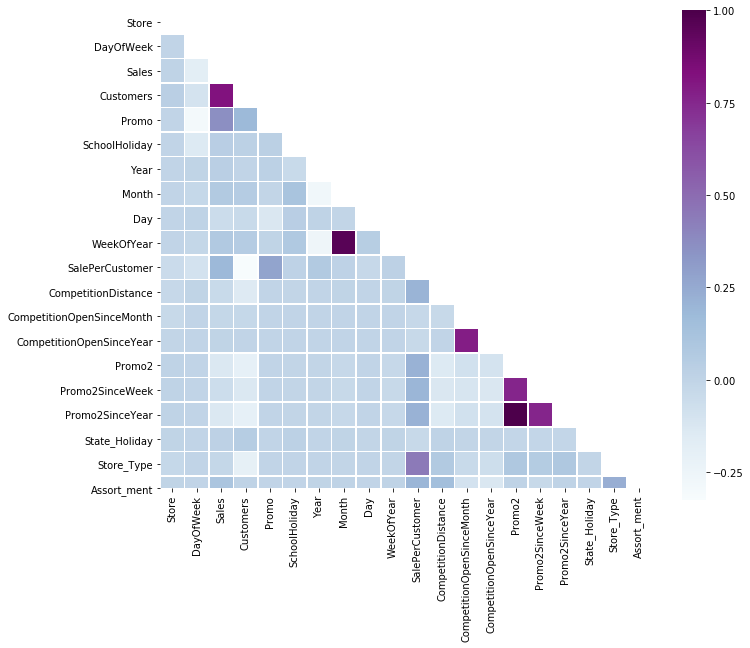

In [11]:
# Exclude 'Open' variable
corr_all = store_train.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

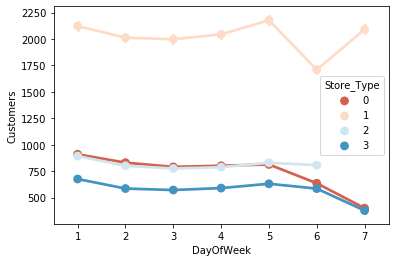

In [12]:
# Customer per day trend based on Store type

sns.pointplot(x = 'DayOfWeek', y = 'Customers', hue = 'Store_Type', 
            col = 'Store', col_wrap = 3, data = store_train,
            palette = 'RdBu') 

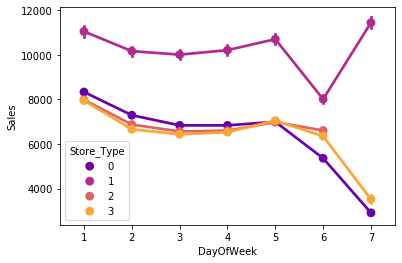

In [13]:
# Sale per day trend based on Store type

sns.pointplot(x = 'DayOfWeek', y = 'Sales', hue = 'Store_Type', 
            col = 'Store', col_wrap = 3, data = store_train,
            palette = 'plasma') 

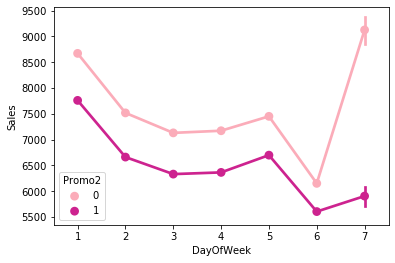

In [14]:
# Sale per day trend based on Promo2

sns.pointplot(x = 'DayOfWeek', y = 'Sales', hue = 'Promo2', 
            data = store_train, palette = 'RdPu') 

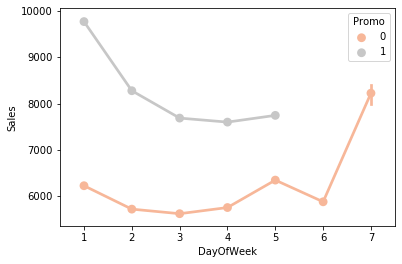

In [15]:
# Sale per day trend based on Promo

sns.pointplot(x = 'DayOfWeek', y = 'Sales', hue = 'Promo', 
            data = store_train, palette = 'RdGy') 

In [156]:
store_train.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State_Holiday', 'Store_Type',
       'Assort_ment'],
      dtype='object')

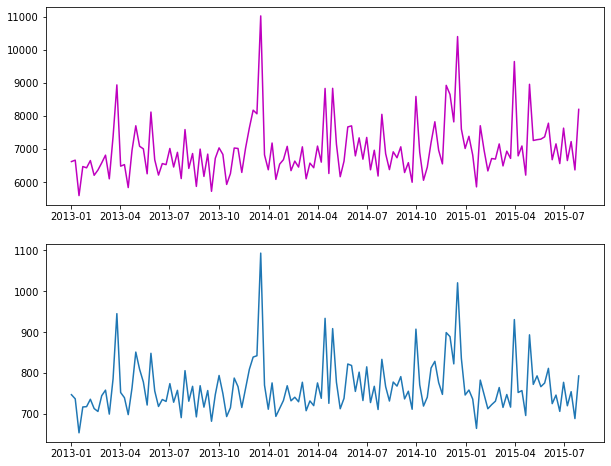

In [162]:
# Average daily sales per week 
f, (ax1, ax2) = plt.subplots(2, figsize = (10, 8))

date_sales_cust = store_train[['Date', 'Sales', 'Customers']].groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax1.plot(date_sales_cust.index, date_sales_cust.Sales, color = 'm')
ax2.plot(date_sales_cust.index, date_sales_cust.Customers)

#### Time-series Analysis

##### Seasonality

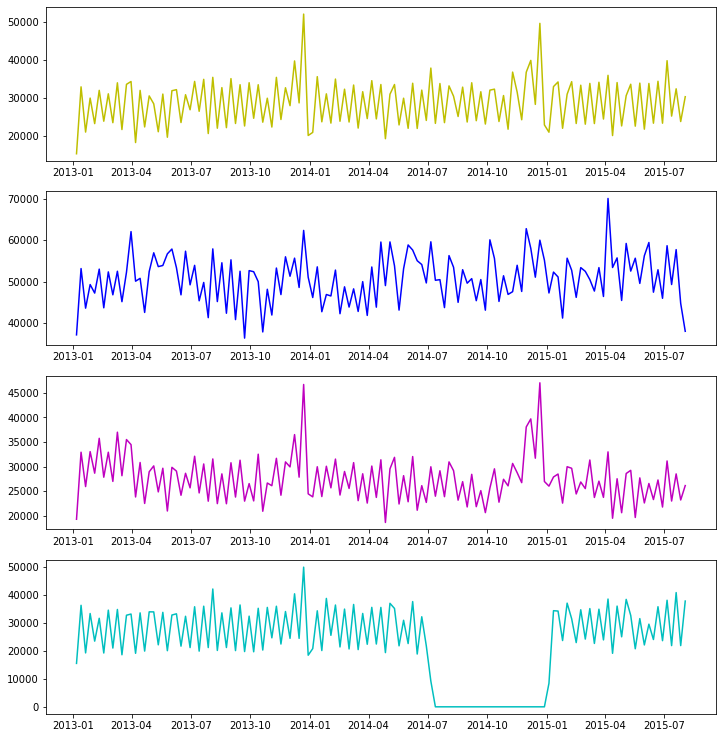

In [155]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types to represent the group
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'] # .sort_index(ascending = True)... solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Downsampling data from days to weeks
sales_a_re = sales_a.resample('W').sum()
sales_b_re = sales_b.resample('W').sum()
sales_c_re = sales_c.resample('W').sum()
sales_d_re = sales_d.resample('W').sum()

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

ax1.plot(sales_a_re, color = 'y')
ax2.plot(sales_b_re, color = 'b')
ax3.plot(sales_c_re, color = 'm')
ax4.plot(sales_d_re, color = 'c')
plt.show()

##### Yearly trend

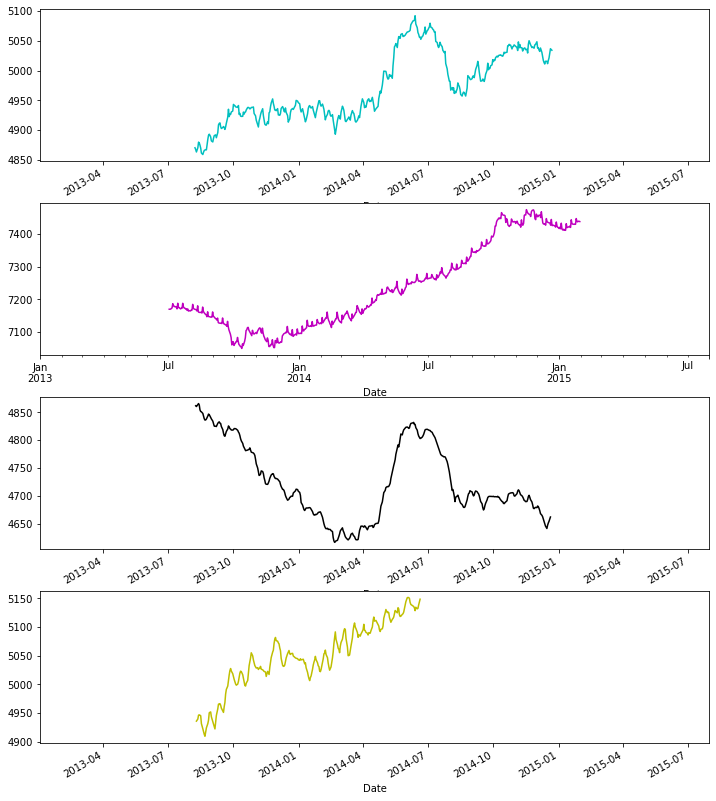

In [154]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 15))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = 'c', ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
pd.plotting.register_matplotlib_converters()
decomposition_b.trend.plot(color = 'm', ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = 'k', ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = 'y', ax = ax4)

plt.subplots_adjust(hspace = 0.27)

## Preprocessing for ML

In [ ]:
store_85_train, store_85_test = train_test_split(store_85, test_size = 0.33, random_state = 33)

In [ ]:
store_85_sales_train, store_85_sales_test = train_test_split(store_85_sales, test_size = 0.33, random_state = 33)

In [ ]:
def Accuracy(df_test, df_predict):
    errors = abs(df_predict - df_test)
    
    Mae = round(np.mean(errors), 2)
    mape = 100 * (errors/df_test)
    rmspe = round(100 * np.sqrt(np.mean((1 - df_predict/ df_test) ** 2)), 2)
    
    accuracy = round(100 - np.mean(mape), 2)
    
    list = [rmspe, accuracy]
    #print('Root MSE %:', rmspe)
    #print('Accuracy %:', accuracy)
    
    return(list)

## fbProphet Method 

In [ ]:
# Create Holidays df for Prophet

state_dates = store_train[(store_train.State_Holiday == 'a') | (store_train.State_Holiday == 'b') & 
                          (store_train.State_Holiday == 'c')].loc[:, 'Date'].values
school_dates = store_train[(store_train.SchoolHoliday == 1)].loc[:, 'Date'].values

state = pd.DataFrame({'holiday' : 'state_holiday', 'ds' : pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday' : 'school_holiday', 'ds' : pd.to_datetime(school_dates)})

holidays = pd.concat((state,school))
holidays.head()

In [ ]:
prophet_train = store_85_sales_train.rename(columns = {'Date' : 'ds', 'Sales' : 'y'})
prophet_test = store_85_sales_test.rename(columns = {'Date' : 'ds', 'Sales' : 'y'})

In [ ]:
# Setting uncertainty interval to 95%

prophet_model = Prophet(interval_width = 0.95, holidays = holidays)
prophet_model.fit(prophet_train)

# Dataframe for forecasting 6 weeks 
# prophet_future_dates = prophet_model.make_future_dataframe(periods = 6*7)
# prophet_future_dates.tail(7)

prophet_forecast = prophet_model.predict(prophet_test)
prophet_forecast = prophet_forecast[['ds', 'yhat']]
prophet_forecast.head()

In [ ]:
prophet_df_test = prophet_test.sort_values(by = 'ds', ascending = True).reset_index().drop('index', axis = 1).y
prophet_df_predict = prophet_forecast.sort_values(by = 'ds', ascending = True).yhat

In [ ]:
Accuracy(prophet_df_test, prophet_df_predict)

## Linear Regression - OLS

In [ ]:
store_train.corr()

In [ ]:
LR_exclude_columns = ['Date', 'PromoInterval', 'Sales', 'SalePerCustomer']
LR_target_column = 'Sales'
LR_feature_columns = [i for i in store_train.columns.values if i not in LR_exclude_columns]

LR_input_data = pd.DataFrame(store_train, columns = LR_feature_columns)
LR_input_data_np = np.asarray(LR_input_data)
LR_input_data = sm.add_constant(LR_input_data_np, has_constant = 'add')
LR_target_data = pd.DataFrame(store_train, columns = [LR_target_column])

In [ ]:
LR_model = sm.OLS(LR_target_data, LR_input_data).fit()
#LR_model.params
LR_model.rsquared

## Linear Regression - Scikit_learn

In [ ]:
LR_feature_train = store_85_train[[i for i in LR_feature_columns]]
LR_target_train = store_85_train[['Sales']]

LR_regressor = LinearRegression()
LR_regressor.fit(LR_feature_train, LR_target_train)

print(LR_regressor.intercept_)
print(LR_regressor.coef_)

In [ ]:
LR_feature_test = store_85_test[[i for i in LR_feature_columns]]
LR_target_test = store_85_test[['Sales']]

LR_predictions = LR_regressor.predict(LR_feature_test)
LR_forecast = pd.DataFrame({'Actual': LR_target_test.Sales, 
                            'Predicted': LR_predictions.flatten()}).reset_index().drop('index', axis = 1)
LR_forecast.head()

In [ ]:
Accuracy(LR_forecast.Actual, LR_forecast.Predicted)

## Neural Network

In [ ]:
NN_exclude_columns = ['Sales', 'Date', 'PromoInterval', 'SalePerCustomer', 'Year', 'Day', 'Month',
                     'DayOfWeek', 'WeekOfYear']
NN_target_column = 'Sales'
NN_feature_columns = [i for i in store_train.columns.values if i not in NN_exclude_columns]

MM_sc = MinMaxScaler()
    
#store_85_train, store_85_test = train_test_split(store_85, test_size = 0.33, random_state = 33)
NN_input_train = MM_sc.fit_transform(store_85_train[[i for i in NN_feature_columns]])
NN_input_test = MM_sc.fit_transform(store_85_test[[i for i in NN_feature_columns]])
NN_target_train = store_85_train[['Sales']].values.reshape(-1,1)
NN_target_test = store_85_test[['Sales']].values.reshape(-1,1)


In [ ]:
def build_regressor(activation = 'relu', optimizer = 'adam'):
    
    
    model = Sequential()
    model.add(Dense(100, input_dim = 14, kernel_initializer = 'normal', activation = activation))
    model.add(Dense(1, kernel_initializer = 'normal'))
    
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    return model

activations = ['relu', 'tanh']
optimizers = ['sgd', 'adam', 'rmsprop']

In [ ]:
def best_params_NN(pair):
    
    o,a = pair
    
    optimizer = optimizers[o]
    activation = activations[a]
    
    cols = ['Activation','Optimizer','Epochs', 'Batch', 'rmspe', 'accuracy']
    acc = pd.DataFrame(columns = cols)

    for i in range(1,10):
        for j in range(100, 500, 100):
        
            NN_estimator = KerasRegressor(build_fn = build_regressor, epochs = j, batch_size = i, verbose = 0)
            NN_estimator.fit(NN_input_train, NN_target_train)
    
            NN_predictions = pd.DataFrame(NN_estimator.predict(NN_input_test))
            #NN_target_test[NN_target_test == 0] = np.mean(NN_target_test)
            #NN_predictions.values[NN_predictions.values == 0] = np.mean(NN_predictions)
        
            accuracy = Accuracy(NN_target_test, NN_predictions)
            acc = acc.append({'Activation': activation, 'Optimizer': optimizer,'Epochs': j, 'Batch': i, 
                                'rmspe': accuracy[0], 'accuracy': accuracy[1]}, ignore_index = True)
        #print(Accuracy(NN_target_test, NN_predictions))
    
    #best_params_index = acc[acc['accuracy'] == acc['accuracy'].max()].index
        
    return(acc)

#### Parallelizing using pool

In [ ]:
# if __name__ == '__main__':
    
pool = Pool(mp.cpu_count())
    
arg_pairs = [(o,a) for o in range(len(optimizers)) for a in range(len(activations))]
results = pool.map(best_params_NN, arg_pairs)
    
pool.close()
pool.join()
    
    # results = pool.starmap(best_params_NN,[(store_train, store_85)])
print(results[1])

In [ ]:
results[0].dtypes

## Random Forest

In [ ]:
RF_feature_train = store_85_train[[i for i in LR_feature_columns]]
RF_target_train = store_85_train[['Sales']]

RF_feature_test = store_85_test[[i for i in LR_feature_columns]]
RF_target_test = store_85_test[['Sales']]

In [ ]:
RF_model = RandomForestRegressor(n_estimators = 50, random_state = 50)
RF_model.fit(RF_feature_train, RF_target_train.values.ravel())

RF_predictions = pd.DataFrame(RF_model.predict(RF_feature_test))
RF_target_test.values[RF_target_test.values == 0] = np.mean(RF_target_test)
RF_predictions.values[RF_predictions.values == 0] = np.mean(RF_predictions)

Accuracy(RF_target_test.values, RF_predictions.values)

In [ ]:
RF_feature_imp = list(RF_model.feature_importances_)
indices = np.argsort(RF_feature_imp)
features_ranked = []

for f in range(RF_feature_train.shape[1]):
    features_ranked.append(RF_feature_train.columns[indices[f]])

# features_ranked
RF_important = pd.Series(data = RF_feature_imp, index = indices).sort_index().tolist()
np.array(RF_important)
np.array(RF_feature_imp)